## Class Activation Maps

Source: http://cnnlocalization.csail.mit.edu/

 A technique for generating class activation maps using the global average pooling (GAP) in CNNs. A class activation map for a particular category indicates the discriminative image regions used by the CNN to identify that category. The procedure for generating these maps is illustrated as follows:

![image_png](http://cnnlocalization.csail.mit.edu/framework.jpg)

Class activation maps could be used to intepret the prediction decision made by the CNN. The left image below shows the class activation map of top 5 predictions respectively, you can see that the CNN is triggered by different semantic regions of the image for different predictions. The right image below shows the CNN learns to localize the common visual patterns for the same object class.

![image.png](attachment:image.png)


Furthermore, the deep features from our networks could be used for generic localization, with newly trained SVM's weights to generate the class activation map, then you could get class-specific saliency map for free. Check the paper for the detail or check the supplementary materials for more visualization.

### **Class activation maps used to visualize the places where the model activates more. It helps you to determine how to improve your model.**

### Import helper functions

In [ ]:
import torch
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import json
import matplotlib
import requests
from io import BytesIO
import time
import os
from torchvision.utils import make_grid, save_image
from PIL import Image

In [ ]:
labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

In [ ]:
def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

In [ ]:
def predict_single(image):
    xb = image.unsqueeze(0)
    preds = model(xb)
    prediction = preds[0]
    result = decode_target(prediction,text_labels=True)
    return result

In [ ]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.binary_cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_score']))
        
class ProteinCnnModel2(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet152(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

### Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization using class activation maps


>
Ramprasaath R. Selvaraju, Michael Cogswell, Abhishek Das, Ramakrishna Vedantam, Devi Parikh, Dhruv Batra
We propose a technique for producing "visual explanations" for decisions from a large class of CNN-based models, making them more transparent. Our approach - Gradient-weighted Class Activation Mapping (Grad-CAM), uses the gradients of any target concept, flowing into the final convolutional layer to produce a coarse localization map highlighting important regions in the image for predicting the concept. Grad-CAM is applicable to a wide variety of CNN model-families: (1) CNNs with fully-connected layers, (2) CNNs used for structured outputs, (3) CNNs used in tasks with multimodal inputs or reinforcement learning, without any architectural changes or re-training. We combine Grad-CAM with fine-grained visualizations to create a high-resolution class-discriminative visualization and apply it to off-the-shelf image classification, captioning, and visual question answering (VQA) models, including ResNet-based architectures. In the context of image classification models, our visualizations (a) lend insights into their failure modes, (b) are robust to adversarial images, (c) outperform previous methods on localization, (d) are more faithful to the underlying model and (e) help achieve generalization by identifying dataset bias. For captioning and VQA, we show that even non-attention based models can localize inputs. We devise a way to identify important neurons through Grad-CAM and combine it with neuron names to provide textual explanations for model decisions. Finally, we design and conduct human studies to measure if Grad-CAM helps users establish appropriate trust in predictions from models and show that Grad-CAM helps untrained users successfully discern a 'stronger' nodel from a 'weaker' one even when both make identical predictions. Our code is available at this https URL, along with a demo at this http URL, and a video at this http URL.
>

https://arxiv.org/abs/1610.02391

In [ ]:
# Install gradcam

!pip install pytorch-gradcam

     |████████████████████████████████| 6.0 MB 5.5 MB/s eta 0:00:01
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5269 sha256=22d5eb34401965601eb2d3ac182211acfbe701b3837a62f90dbabdf3926a8e2a
  Stored in directory: /root/.cache/pip/wheels/06/e7/da/b13a71980c3a787414e5ff8e156701c561c6322636396d71cc
Successfully built pytorch-gradcam


In [ ]:
import gradcam
from gradcam.utils import visualize_cam
from gradcam.gradcam import GradCAMpp
import numpy as np

In [ ]:
# Transform test image

norm_vals = ([0.0793, 0.0530, 0.0545], [0.1290, 0.0886, 0.1376])

trans = transforms.Compose([
    transforms.Resize(256), 
    transforms.ToTensor(), 
    transforms.Normalize(*norm_vals),
])

### NOTE:- 
This activation_map function supports only **pretrained resnet protien model** (created by given funtion on competition starter notebooks), but works on any version of resnet (**resnet18, resnet34, resnet50, res101, resnet152**).

In [ ]:
# Function used to create activation map

def activation_map(img_path):
    
    img = Image.open(img_path)
    
    print(predict_single(trans(img)))

    torch_img = transforms.Compose([ transforms.Resize((224)),transforms.ToTensor()])(img).to('cpu')

    normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]
    
    model.eval()

    model_conf = dict(model_type='resnet', arch=model, layer_name='layer4')

    mask_pp, _ = GradCAMpp.from_config(**model_conf)(normed_torch_img)
    
    _ , map = visualize_cam(mask_pp, torch_img)

    map_image = make_grid([torch_img.cpu() , map])
    
    return transforms.ToPILImage()(map_image)

### Visulaize model's prediction

In [ ]:
# Get pretrained model obtained using the stratified-sampling-and-normalization notebook and load the path.
model_path = 'resnet101_final_02.pth'

In [ ]:
# Setup model

model = torch.load(model_path, map_location='cpu').network
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import glob

# Load test image directory
test_img = glob.glob('../input/jovian-pytorch-z2g/Human protein atlas/test/*')

Plasma membrane(7)


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


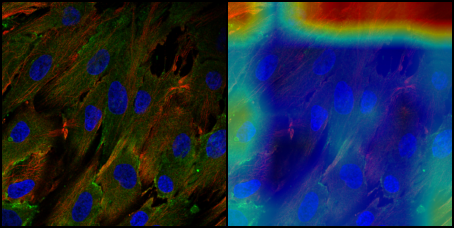

In [ ]:
# Visualize output 

activation_map(test_img[110])

                                      
                                            Low                                 High

![image.png](attachment:image.png)

### You could observe that, in red areas model activates. So the we could visualize how our model works.

# Copy and Edit the kernel -> Load your model -> Visualize your model performance !!!

## More Examples

Nucleoplasm(4)


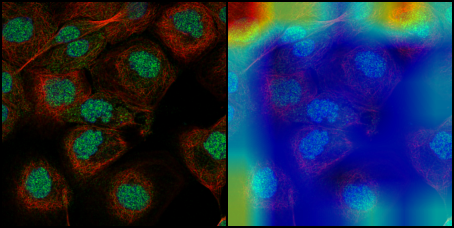

In [ ]:
activation_map(test_img[112])

Cytosol(6)


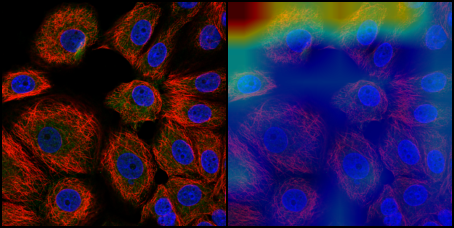

In [ ]:
activation_map(test_img[12])